In [2]:
import numpy as np
import os
import cv2
import random
import argparse
import cvxpy as cvx
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
%matplotlib notebook
%matplotlib inline

 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from sklearn.decomposition import PCA
from skimage.color import rgb2gray
#from src_algorithm import src_algorithm
from DMD_video_sampling import parse_videos
from face_detection import process_DMD_snapshots
font_small = {'fontsize': 8}
font_large = {'fontsize': 10}

shape = (6, 7)
IGNORE_FILES = ['.DS_Store']
path = os.path.join(os.getcwd(), 'Figures')

In [3]:
def split_train_test(data_folder):

    if not os.path.isdir(os.path.join(data_folder, "train")):
        print("Train folder with data does not exist, exiting..")
        return

    test_path = os.path.join(data_folder, "test")
    train_path = os.path.join(data_folder, "train")

    if not os.path.isdir(test_path):
        os.mkdir(test_path)

    for dir in os.listdir(train_path): #list of subjects
        i = 0
        if dir in IGNORE_FILES:
            continue

        if not os.path.isdir(os.path.join(test_path, dir)): # create folder for each subjet in test folder
            os.mkdir(os.path.join(test_path, dir))

        subject_path = os.path.join(train_path, dir)

        for file in os.listdir(subject_path):

            l = len(os.listdir(subject_path))
            i += 1

            if l > 5:
                if int(len(os.listdir(subject_path)) * 0.3) % i == 0:
                    k = random.choice(os.listdir(os.path.join(train_path, dir)))
                    os.rename(os.path.join(train_path, dir, k),
                              os.path.join(test_path, dir, k))

            elif l <= 5:
                if i == 1: ## Sample a single test file (should optimally have more training data than this, so one test sample is sufficient)
                    k = random.choice(os.listdir(os.path.join(train_path, dir)))

                    os.rename(os.path.join(train_path, dir, k),
                              os.path.join(test_path, dir, k))

In [14]:
def normalize_data_column(img_matrix):
    normalized_img = img_matrix / np.sqrt(np.sum(img_matrix ** 2))
    return normalized_img

def pca_dim_reduction(train_imgs, test_imgs, n_features):
    img_matrix_train = train_imgs.transpose()
    img_matrix_test = test_imgs.transpose()
    pca = PCA(n_components=n_features, svd_solver='randomized', whiten=True).fit(img_matrix_train)
    pca.fit(img_matrix_train)
    resized_matrix_train = pca.transform(img_matrix_train)
    resized_matrix_test = pca.transform(img_matrix_test)
    resized_matrix_train = resized_matrix_train.transpose()
    resized_matrix_test = resized_matrix_test.transpose()

    return resized_matrix_train, resized_matrix_test

def prep_train_test(train_path, test_path, options: dict, num_folders):
    init_data_matrix = True
    TrainSet = {}
    class_label_train = []
    TestSet = {}
    class_label_test = []
    test_file = []
    folder_count = 0
    
    files_count = 0

    dims = options['dims'] #either a tuple for downsampling or an integer for pca

    for folder in os.listdir(train_path):
        init_class_matrix = True
        if folder in IGNORE_FILES:
            continue
        folder_count += 1
        if folder_count > num_folders and num_folders < 31:
            break
        class_folder = train_path + folder + os.sep
        class_vector = os.listdir(class_folder)
        
        files_count += len(class_vector)

        for img_file in class_vector:
            if img_file in IGNORE_FILES or img_file.find('.pgm') == -1:
                continue
            class_label_train.append(folder)
            img_path = train_path + folder + os.sep + img_file # absolute path to image
            X_orig = cv2.imread(img_path)

            try: # convert to greyscale if image is rgb
                X_orig.shape[2]
                X_orig = rgb2gray(X_orig)
            except IndexError:
                pass

            if options['feature_selection'] == 'downsampling':
                X = cv2.resize(X_orig, dims, interpolation = cv2.INTER_AREA)

            else:
                X = X_orig

            X = X.reshape(-1, 1)
            X = normalize_data_column(X)

            if init_class_matrix:
                D_c = X # initialize data matrix
                init_class_matrix = False
            else:
                D_c = np.hstack((D_c, X))

        if init_data_matrix: # this will run the first time
            D_train = D_c
            init_data_matrix = False
        else:
            D_train = np.hstack((D_train, D_c))

    # Now process test data
    init_data_matrix = True
    folder_count = 0

    for folder in os.listdir(test_path):
        init_class_matrix = True
        if folder in IGNORE_FILES:
            continue
        
        folder_count += 1
        if folder_count > num_folders:
            break
        
        class_folder = test_path + folder + os.sep
        class_vector = os.listdir(class_folder)

        for img_file in class_vector:
            if img_file in IGNORE_FILES or img_file.find('.pgm') == -1:
                continue
            class_label_test.append(folder)
            img_path = test_path + folder + os.sep + img_file  # absolute path to image
            test_file.append(img_path)
            X_orig = cv2.imread(img_path)

            try:  # convert to greyscale if image is rgb
                X_orig.shape[2]
                X_orig = rgb2gray(X_orig)
            except IndexError:
                pass

            if options['feature_selection'] == 'downsampling':
                X = cv2.resize(X_orig, dims, interpolation = cv2.INTER_AREA)
            else:
                X = X_orig

            X = X.reshape(-1, 1)
            X = normalize_data_column(X)

            if init_class_matrix:
                D_c = X  # initialize data matrix
                init_class_matrix = False
            else:
                D_c = np.hstack((D_c, X))

        if init_data_matrix:  # this will run the first time
            D_test = D_c
            init_data_matrix = False
        else:
            D_test = np.hstack((D_test, D_c))

    if options['feature_selection'] == 'pca':
        D_train, D_test = pca_dim_reduction(D_train, D_test, dims)

    TrainSet['X'] = D_train
    TrainSet['y'] = np.array(class_label_train)
    TestSet['X'] = D_test
    TestSet['y'] = np.array(class_label_test)
    TestSet['files'] = test_file
    
    print("FILES COUnT: ", files_count)

    return TrainSet, TestSet

def src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty):
    classes = np.unique(TrainSet['y']) # which classes have been acquainted
    identity = []
    failed_imgs = []
    results = [] # a list of dictionaries with residuals and threshold certainty for each test sample
    num_recognized = 0
    false_pos = 0
    coeff_vectors = []
    runtimes = []

    for i in range(num_test_samples):

        y = TestSet['X'][:,i]
        D = TrainSet['X'] # Data matrix
        m, n = D.shape
        
        subject = {}
        subject['subject'] = TestSet['y'][i] # the true identity of the subject

        # do L1 optimization
        x = cvx.Variable(n)
        objective = cvx.Minimize(cvx.norm(x, 1))
        #constraints = [D@x == y]
        z = D @ x - y
        constraints = [cvx.norm(z, 2) <= sigma]
        prob = cvx.Problem(objective, constraints)
        
        result = prob.solve(verbose=True) # runs economy optimizer by default
        
        xp = np.array(x.value).squeeze()
        coeff_vectors.append(xp)
        #runtime = prob.solver_stats.solve_time
        #runtimes.append(runtime)

        residuals = np.zeros((num_classes))

        # calculate residuals for each class
        #for j in range(num_classes):
        #    idx = np.where(classes[j] == TrainSet['y'])
        #    last_index = np.size(idx) - 1
        #    residuals[j] = np.linalg.norm(y - TrainSet['X'][:,idx[0][0]:idx[0][last_index]+1].dot(xp[idx]))

        #min_res = np.min(residuals)

        #mean_res = np.mean(residuals)
        #certainty = 1-min_res/mean_res

        #label_index = np.argmin(residuals)

        #if classes[label_index] != TestSet['y'][i] or thresh_certainty > certainty:
        #if thresh_certainty > certainty:
        #    failed_imgs.append(TestSet['files'][i])
        #    identity.append(None)
        #    subject['predicted'] = None
        #else:
        #    subject['predicted'] = classes[label_index]
        #    identity.append(classes[label_index])
        #    num_recognized += 1
            
        
        #subject['residuals'] = residuals
        #subject['certainty'] = certainty
        
        #results.append(subject)

    ### Calculate accuracy ###
    #correct_num = [i for i in range(len(identity)) if identity[i] == TestSet['y'][i]]
    #accuracy = len(correct_num)/num_test_samples * 100
    #print(f"Predicted correctly: {len(correct_num)} out of {np.size(TestSet['y'])} test samples")
    print("done")

    return 0

In [15]:
data_folder = 'Data'
dest = os.path.join(os.getcwd(), data_folder)

#split_train_test(dest)

## Use this for finding training time scaled with data

In [16]:
### Plot src scale with input size ###
data_folder = 'Data'
dest = os.path.join(os.getcwd(), data_folder)
train_path = os.path.join(dest, 'train') + os.sep
test_path = os.path.join(dest, 'test') + os.sep
    
options    = {'feature_selection': 'downsampling', 'dims': (5,5)}
times_scs      = []
train_size_scs = []
sigma = 0.0001
thresh_certainty = 0

for n in range(5,40,5):
    TrainSet, TestSet = prep_train_test(train_path, test_path, options, n)
    print(TrainSet['X'].shape, TrainSet['y'].shape, TestSet['X'].shape, TestSet['y'].shape)
    num_classes = len(set(TrainSet['y']))
    num_test_samples = len(list(TestSet['y']))
    
    #if n == 35:
    #    print(TrainSet['X'][:,0], TestSet['X'][:,0])
    
    #start = timeit.default_timer()
    src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty)
    #stop = timeit.default_timer()
    #times_scs.append(stop - start)
    #train_size_scs.append(TrainSet['X'].shape[1])

print(len(times), len(train_size))

FILES COUnT:  325
(25, 315) (315,) (25, 10) (10,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.000e-04  +1e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.883e+00  +1.416e-02  +3e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -1.408e-01  +8.564e-02  +6e+01  2e-01  1e-02  2e-01  9e-02  0.9448  1e-01   1  1  2 |  0  0
 3  +3.033e-01  +4.247e-01  +4e+01  2e-01  9e-03  1e-01  7e-02  0.4961  6e-01   2  2  2 |  0  0
 4  +3.708e-01  +4.737e-01  +4e+01  2e-01  6e-03  1e-01  7e-02  0.1936  6e-01   2  2  2 |  0  0
 5  +7.103e-01  +7.786e-01  +3e+01  1e-01  3e-03  8e-02  5e-02  0.3817  3e-01   3  3  3 |  0  0
 6  +9.387e-01  +9.792e-01  +2e+01  9e-02  2e-03  5e-02  3e-02  0.4309  2e-01   2  2  2 |  0  0
 7  +9.301e-01  +9.665e-01  +2e+01  7e-02  2e-03  4e-02  3e-02  0.0908  7e-01   2  2  2 |  0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.000e-04  +1e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.884e+00  +1.837e-02  +3e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -7.828e-01  +1.337e-01  +2e+02  3e-01  5e-02  1e+00  3e-01  0.5554  3e-01   1  1  2 |  0  0
 3  -1.697e-02  +3.875e-01  +1e+02  3e-01  2e-02  4e-01  2e-01  0.5719  2e-01   2  2  2 |  0  0
 4  +8.107e-01  +1.217e+00  +1e+02  2e-01  1e-02  4e-01  2e-01  0.1325  8e-01   2  2  2 |  0  0
 5  +6.029e-01  +8.736e-01  +9e+01  2e-01  1e-02  3e-01  1e-01  0.3178  6e-01   2  3  2 |  0  0
 6  +1.613e+00  +1.750e+00  +6e+01  1e-01  4e-03  2e-01  9e-02  0.5420  4e-01   3  3  3 |  0  0
 7  +1.416e+00  +1.461e+00  +5e+01  9e-02  4e-03  6e-02  8e-02  0.5801  7e-01   2  2  2 |  0  0
 8  +1.804e+00  +1.814e+00  +2e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.000e-04  +1e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.883e+00  +1.422e-02  +3e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -1.551e-01  +8.632e-02  +6e+01  2e-01  1e-02  3e-01  1e-01  0.9358  2e-01   1  1  1 |  0  0
 3  +3.255e-01  +4.489e-01  +5e+01  2e-01  9e-03  1e-01  8e-02  0.5242  6e-01   2  2  2 |  0  0
 4  +4.014e-01  +4.968e-01  +4e+01  2e-01  7e-03  1e-01  7e-02  0.2591  7e-01   2  2  2 |  0  0
 5  +8.286e-01  +8.742e-01  +2e+01  1e-01  2e-03  5e-02  4e-02  0.5492  2e-01   3  3  3 |  0  0
 6  +7.528e-01  +7.781e-01  +2e+01  5e-02  2e-03  3e-02  3e-02  0.3896  6e-01   2  2  2 |  0  0
 7  +8.341e-01  +8.512e-01  +2e+01  6e-02  2e-03  2e-02  3e-02  0.3275  6e-01   3  3  3 |  0  0
 8  +1.004e+00  +1.010e+00  +8e+00  2e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.986e-25  -1.000e-04  +2e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.920e+00  +9.392e-03  +6e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.736e-01  +4.323e-02  +2e+02  2e-01  2e-02  4e-01  1e-01  0.8120  9e-02   1  1  1 |  0  0
 3  +7.270e-02  +2.003e-01  +9e+01  2e-01  1e-02  1e-01  7e-02  0.7042  4e-01   2  2  2 |  0  0
 4  +4.306e-01  +4.783e-01  +5e+01  1e-01  4e-03  6e-02  4e-02  0.6323  3e-01   2  2  2 |  0  0
 5  +5.580e-01  +6.047e-01  +5e+01  1e-01  3e-03  6e-02  4e-02  0.0736  9e-01   2  3  3 |  0  0
 6  +9.849e-01  +9.989e-01  +3e+01  1e-01  1e-03  2e-02  2e-02  0.6942  5e-01   3  3  3 |  0  0
 7  +8.342e-01  +8.405e-01  +3e+01  4e-02  1e-03  1e-02  2e-02  0.4425  6e-01   3  3  3 |  0  0
 8  +1.041e+00  +1.043e+00  +7e+00  8e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.022e-24  -1.000e-04  +2e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.920e+00  +9.057e-03  +6e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.485e-01  +4.036e-02  +1e+02  2e-01  2e-02  4e-01  1e-01  0.8264  7e-02   1  1  1 |  0  0
 3  +4.920e-02  +1.729e-01  +8e+01  2e-01  9e-03  1e-01  6e-02  0.6872  4e-01   2  2  2 |  0  0
 4  +3.187e-01  +3.745e-01  +5e+01  1e-01  5e-03  6e-02  4e-02  0.5516  2e-01   2  2  2 |  0  0
 5  +4.103e-01  +4.652e-01  +5e+01  1e-01  3e-03  6e-02  4e-02  0.0558  9e-01   2  2  3 |  0  0
 6  +7.639e-01  +7.878e-01  +3e+01  1e-01  1e-03  3e-02  3e-02  0.5755  5e-01   3  3  3 |  0  0
 7  +9.907e-01  +9.953e-01  +2e+01  5e-02  6e-04  8e-03  1e-02  0.7716  4e-01   3  3  3 |  0  0
 8  +9.640e-01  +9.679e-01  +2e+01  3e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.874e-25  -1.000e-04  +2e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.921e+00  +1.475e-02  +6e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -5.570e-01  +1.086e-01  +3e+02  3e-01  3e-02  7e-01  2e-01  0.7016  3e-01   2  2  2 |  0  0
 3  +2.050e-01  +4.337e-01  +2e+02  2e-01  2e-02  3e-01  1e-01  0.6725  3e-01   2  2  2 |  0  0
 4  +6.731e-01  +8.205e-01  +1e+02  2e-01  1e-02  2e-01  1e-01  0.3787  6e-01   2  2  3 |  0  0
 5  +9.244e-01  +9.665e-01  +7e+01  1e-01  5e-03  5e-02  6e-02  0.7082  3e-01   3  3  2 |  0  0
 6  +1.009e+00  +1.029e+00  +5e+01  8e-02  3e-03  3e-02  4e-02  0.5196  5e-01   3  2  2 |  0  0
 7  +1.266e+00  +1.277e+00  +4e+01  6e-02  1e-03  2e-02  3e-02  0.4535  3e-01   3  3  3 |  0  0
 8  +1.281e+00  +1.285e+00  +3e+01  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.078e-24  -1.000e-04  +2e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.921e+00  +9.551e-03  +6e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.752e-01  +4.474e-02  +2e+02  2e-01  2e-02  4e-01  1e-01  0.8115  9e-02   1  1  2 |  0  0
 3  +1.254e-01  +2.255e-01  +9e+01  2e-01  1e-02  1e-01  7e-02  0.7741  4e-01   2  2  2 |  0  0
 4  +5.446e-01  +5.702e-01  +4e+01  1e-01  3e-03  3e-02  3e-02  0.7500  2e-01   2  2  2 |  0  0
 5  +6.464e-01  +6.693e-01  +4e+01  1e-01  2e-03  3e-02  3e-02  0.1387  8e-01   3  3  3 |  0  0
 6  +9.435e-01  +9.511e-01  +2e+01  7e-02  9e-04  1e-02  2e-02  0.6504  4e-01   3  3  3 |  0  0
 7  +8.884e-01  +8.936e-01  +2e+01  5e-02  9e-04  9e-03  2e-02  0.2462  8e-01   3  3  2 |  0  0
 8  +1.025e+00  +1.027e+00  +1e+01  2e-02  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.075e-25  -1.000e-04  +2e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.920e+00  +9.469e-03  +6e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.609e-01  +4.393e-02  +1e+02  2e-01  2e-02  4e-01  1e-01  0.8198  9e-02   1  1  1 |  0  0
 3  +1.122e-01  +2.111e-01  +8e+01  2e-01  9e-03  1e-01  6e-02  0.7655  4e-01   2  2  2 |  0  0
 4  +4.794e-01  +5.087e-01  +4e+01  1e-01  3e-03  4e-02  3e-02  0.7077  2e-01   2  2  2 |  0  0
 5  +5.647e-01  +5.909e-01  +4e+01  1e-01  2e-03  3e-02  3e-02  0.1348  8e-01   2  3  3 |  0  0
 6  +9.023e-01  +9.107e-01  +2e+01  8e-02  9e-04  1e-02  2e-02  0.6738  4e-01   3  3  3 |  0  0
 7  +8.895e-01  +8.944e-01  +2e+01  6e-02  8e-04  8e-03  2e-02  0.3553  6e-01   3  3  3 |  0  0
 8  +9.979e-01  +9.983e-01  +7e+00  1e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.446e-25  -1.000e-04  +3e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.933e+00  +7.036e-03  +9e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.068e-01  +2.916e-02  +2e+02  3e-01  2e-02  5e-01  1e-01  0.7953  6e-02   1  1  1 |  0  0
 3  -3.351e-02  +1.185e-01  +1e+02  2e-01  1e-02  2e-01  7e-02  0.6543  4e-01   2  2  2 |  0  0
 4  +2.424e-01  +2.967e-01  +6e+01  2e-01  5e-03  6e-02  3e-02  0.6422  2e-01   2  2  2 |  0  0
 5  +3.307e-01  +3.800e-01  +6e+01  2e-01  4e-03  6e-02  3e-02  0.1076  8e-01   2  3  3 |  0  0
 6  +5.653e-01  +5.934e-01  +5e+01  1e-01  2e-03  3e-02  3e-02  0.4307  6e-01   3  3  3 |  0  0
 7  +9.751e-01  +9.876e-01  +3e+01  9e-02  7e-04  2e-02  2e-02  0.5799  2e-01   3  3  3 |  0  0
 8  +9.506e-01  +9.623e-01  +3e+01  7e-02  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.719e-25  -1.000e-04  +3e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.934e+00  +1.149e-02  +9e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.451e-01  +8.004e-02  +3e+02  3e-01  2e-02  5e-01  2e-01  0.8386  2e-01   1  1  1 |  0  0
 3  +1.245e-01  +5.077e-01  +3e+02  3e-01  2e-02  4e-01  2e-01  0.1245  8e-01   2  2  2 |  0  0
 4  +8.944e-01  +1.110e+00  +2e+02  2e-01  9e-03  2e-01  1e-01  0.4507  3e-01   2  3  2 |  0  0
 5  +8.565e-01  +1.049e+00  +2e+02  2e-01  9e-03  2e-01  1e-01  0.1166  8e-01   2  2  2 |  0  0
 6  +1.186e+00  +1.241e+00  +1e+02  8e-02  4e-03  7e-02  5e-02  0.7018  3e-01   2  2  2 |  0  0
 7  +1.384e+00  +1.400e+00  +5e+01  5e-02  2e-03  2e-02  3e-02  0.6882  3e-01   2  2  2 |  0  0
 8  +1.499e+00  +1.505e+00  +3e+01  3e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.879e-25  -1.000e-04  +3e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.934e+00  +1.275e-02  +9e+02  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.890e-01  +9.309e-02  +3e+02  3e-01  3e-02  5e-01  2e-01  0.8089  2e-01   2  2  2 |  0  0
 3  +5.348e-01  +6.460e-01  +2e+02  2e-01  1e-02  1e-01  1e-01  0.7964  4e-01   2  2  2 |  0  0
 4  +7.221e-01  +7.997e-01  +1e+02  2e-01  8e-03  9e-02  8e-02  0.3176  3e-01   2  2  3 |  0  0
 5  +1.046e+00  +1.066e+00  +7e+01  9e-02  3e-03  3e-02  3e-02  0.7338  2e-01   2  3  2 |  0  0
 6  +1.193e+00  +1.203e+00  +4e+01  6e-02  1e-03  1e-02  2e-02  0.5120  3e-01   2  2  2 |  0  0
 7  +1.275e+00  +1.280e+00  +3e+01  5e-02  9e-04  9e-03  2e-02  0.4245  5e-01   2  2  2 |  0  0
 8  +1.350e+00  +1.353e+00  +2e+01  2e-02  5e-

16  +1.448e+00  +1.448e+00  +2e+00  2e-03  3e-05  1e-04  9e-04  0.2642  6e-01   3  3  3 |  0  0
17  +1.454e+00  +1.454e+00  +8e-01  9e-04  1e-05  7e-05  4e-04  0.5887  1e-01   3  3  2 |  0  0
18  +1.457e+00  +1.457e+00  +4e-01  5e-04  7e-06  4e-05  2e-04  0.5545  2e-01   3  2  2 |  0  0
19  +1.457e+00  +1.457e+00  +4e-01  4e-04  6e-06  3e-05  2e-04  0.2901  7e-01   3  3  3 |  0  0
20  +1.458e+00  +1.458e+00  +1e-01  1e-04  2e-06  8e-06  5e-05  0.8358  1e-01   3  2  3 |  0  0
21  +1.459e+00  +1.459e+00  +2e-02  3e-05  4e-07  2e-06  1e-05  0.8743  1e-01   3  3  3 |  0  0
22  +1.459e+00  +1.459e+00  +3e-03  3e-06  4e-08  2e-07  1e-06  0.9024  1e-02   3  3  3 |  0  0
23  +1.459e+00  +1.459e+00  +1e-04  1e-07  2e-09  9e-09  6e-08  0.9619  7e-03   2  2  2 |  0  0
24  +1.459e+00  +1.459e+00  +3e-06  3e-09  4e-11  2e-10  1e-09  0.9761  1e-04   2  2  2 |  0  0
25  +1.459e+00  +1.459e+00  +5e-08  5e-11  7e-13  4e-12  2e-11  0.9833  1e-04   1  1  1 |  0  0
26  +1.459e+00  +1.459e+00  +5e-10  6e-1

12  +1.038e+00  +1.038e+00  +1e+00  9e-04  2e-05  9e-05  5e-04  0.5905  1e-01   4  4  4 |  0  0
13  +1.041e+00  +1.041e+00  +6e-01  5e-04  1e-05  5e-05  3e-04  0.6032  3e-01   4  4  4 |  0  0
14  +1.042e+00  +1.042e+00  +5e-01  4e-04  9e-06  4e-05  3e-04  0.3812  4e-01   4  3  3 |  0  0
15  +1.043e+00  +1.043e+00  +2e-01  2e-04  4e-06  2e-05  1e-04  0.5726  1e-01   4  3  3 |  0  0
16  +1.044e+00  +1.044e+00  +9e-02  8e-05  2e-06  7e-06  5e-05  0.8580  3e-01   3  3  3 |  0  0
17  +1.044e+00  +1.044e+00  +2e-02  2e-05  4e-07  2e-06  1e-05  0.8232  6e-02   3  3  3 |  0  0
18  +1.044e+00  +1.044e+00  +5e-03  5e-06  1e-07  4e-07  3e-06  0.7924  5e-02   3  2  2 |  0  0
19  +1.044e+00  +1.044e+00  +5e-04  5e-07  1e-08  4e-08  3e-07  0.9840  9e-02   3  2  2 |  0  0
20  +1.044e+00  +1.044e+00  +5e-05  4e-08  9e-10  4e-09  3e-08  0.9578  5e-02   2  2  2 |  0  0
21  +1.044e+00  +1.044e+00  +2e-06  2e-09  4e-11  2e-10  1e-09  0.9858  3e-02   2  2  2 |  0  0
22  +1.044e+00  +1.044e+00  +2e-08  2e-1

16  +1.549e+00  +1.549e+00  +1e+00  1e-03  2e-05  1e-04  6e-04  0.7034  6e-01   3  3  3 |  0  0
17  +1.555e+00  +1.554e+00  +3e-01  3e-04  4e-06  2e-05  1e-04  0.7872  3e-02   3  2  2 |  0  0
18  +1.556e+00  +1.556e+00  +8e-02  8e-05  1e-06  7e-06  4e-05  0.8146  1e-01   3  2  2 |  0  0
19  +1.556e+00  +1.556e+00  +3e-02  3e-05  3e-07  2e-06  1e-05  0.6855  5e-02   3  3  3 |  0  0
20  +1.556e+00  +1.556e+00  +6e-03  6e-06  7e-08  5e-07  3e-06  0.8935  1e-01   3  3  3 |  0  0
21  +1.556e+00  +1.556e+00  +1e-04  1e-07  1e-09  9e-09  5e-08  0.9843  2e-03   2  2  2 |  0  0
22  +1.556e+00  +1.556e+00  +2e-06  2e-09  3e-11  2e-10  1e-09  0.9779  1e-04   2  2  2 |  0  0
23  +1.556e+00  +1.556e+00  +3e-08  3e-11  4e-13  3e-12  2e-11  0.9866  1e-04   2  1  1 |  0  0
24  +1.556e+00  +1.556e+00  +3e-10  3e-13  4e-15  3e-14  2e-13  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.5e-13, reltol=2.2e-10, abstol=3.4e-10).
Runtime: 0.053655 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich S

 6  +1.211e+00  +1.253e+00  +1e+02  1e-01  5e-03  6e-02  8e-02  0.5147  8e-01   2  2  2 |  0  0
 7  +1.636e+00  +1.649e+00  +6e+01  5e-02  2e-03  2e-02  3e-02  0.6802  2e-01   2  2  2 |  0  0
 8  +1.754e+00  +1.763e+00  +5e+01  4e-02  1e-03  2e-02  3e-02  0.2999  5e-01   2  2  2 |  0  0
 9  +1.905e+00  +1.904e+00  +3e+01  2e-02  6e-04  2e-03  2e-02  0.9890  5e-01   3  2  2 |  0  0
10  +1.897e+00  +1.895e+00  +3e+01  2e-02  5e-04  2e-03  1e-02  0.2471  6e-01   3  3  3 |  0  0
11  +2.010e+00  +2.010e+00  +1e+01  1e-02  2e-04  1e-03  7e-03  0.5383  1e-01   3  3  3 |  0  0
12  +2.062e+00  +2.062e+00  +1e+01  8e-03  2e-04  8e-04  5e-03  0.8706  7e-01   3  3  3 |  0  0
13  +2.072e+00  +2.072e+00  +8e+00  6e-03  1e-04  6e-04  4e-03  0.5766  6e-01   3  3  3 |  0  0
14  +2.104e+00  +2.103e+00  +4e+00  3e-03  7e-05  3e-04  2e-03  0.7275  4e-01   3  3  3 |  0  0
15  +2.129e+00  +2.129e+00  +2e+00  2e-03  3e-05  2e-04  1e-03  0.9636  5e-01   3  3  3 |  0  0
16  +2.130e+00  +2.130e+00  +2e+00  2e-0

14  +1.184e+00  +1.184e+00  +2e+00  2e-03  4e-05  1e-04  1e-03  0.4773  7e-01   3  3  2 |  0  0
15  +1.190e+00  +1.190e+00  +1e+00  1e-03  2e-05  8e-05  6e-04  0.5324  2e-01   3  2  2 |  0  0
16  +1.194e+00  +1.194e+00  +7e-01  8e-04  1e-05  5e-05  3e-04  0.5837  3e-01   3  2  3 |  0  0
17  +1.195e+00  +1.195e+00  +5e-01  7e-04  1e-05  4e-05  3e-04  0.6007  7e-01   3  3  3 |  0  0
18  +1.196e+00  +1.196e+00  +3e-01  4e-04  6e-06  2e-05  2e-04  0.5689  3e-01   3  3  3 |  0  0
19  +1.197e+00  +1.197e+00  +9e-02  1e-04  2e-06  7e-06  5e-05  0.9890  3e-01   3  3  3 |  0  0
20  +1.198e+00  +1.198e+00  +2e-02  3e-05  4e-07  2e-06  1e-05  0.9266  2e-01   3  3  3 |  0  0
21  +1.198e+00  +1.198e+00  +2e-03  2e-06  3e-08  1e-07  1e-06  0.9214  1e-03   3  3  3 |  0  0
22  +1.198e+00  +1.198e+00  +3e-05  4e-08  6e-10  2e-09  2e-08  0.9890  8e-03   2  2  2 |  0  0
23  +1.198e+00  +1.198e+00  +4e-07  5e-10  7e-12  3e-11  2e-10  0.9890  1e-04   2  1  1 |  0  0
24  +1.198e+00  +1.198e+00  +4e-09  5e-1


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.765e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.941e+00  +9.491e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.803e-01  +6.139e-02  +4e+02  3e-01  3e-02  6e-01  2e-01  0.7620  2e-01   1  1  2 |  0  0
 3  +4.827e-01  +6.955e-01  +3e+02  3e-01  2e-02  2e-01  1e-01  0.6411  6e-01   2  2  2 |  0  0
 4  +4.163e-01  +5.837e-01  +3e+02  2e-01  2e-02  2e-01  1e-01  0.2085  7e-01   2  2  2 |  0  0
 5  +7.084e-01  +7.575e-01  +1e+02  9e-02  5e-03  6e-02  4e-02  0.7013  6e-02   2  2  2 |  0  0
 6  +6.874e-01  +7.310e-01  +1e+02  1e-01  5e-03  5e-02  4e-02  0.1012  9e-01   3  3  2 |  0  0
 7  +8.124e-01  +8.381e-01  +1e+02  1e-01  4e-03  3e-02  4e-02  0.3984  8e-01   2  2  2 |  0  0
 8  +9.008e-01  +9.043e-01  +6e+01  7e-02  2e-

23  +1.027e+00  +1.027e+00  +5e-03  4e-06  7e-08  3e-07  2e-06  0.2814  5e-01   4  3  4 |  0  0
24  +1.027e+00  +1.027e+00  +5e-03  4e-06  7e-08  3e-07  2e-06  0.1218  8e-01   3  3  3 |  0  0
25  +1.027e+00  +1.027e+00  +2e-03  2e-06  3e-08  1e-07  9e-07  0.8777  4e-01   4  4  3 |  0  0
26  +1.027e+00  +1.027e+00  +2e-03  1e-06  2e-08  9e-08  7e-07  0.5058  4e-01   3  3  3 |  0  0
27  +1.027e+00  +1.027e+00  +5e-04  4e-07  7e-09  3e-08  2e-07  0.7157  4e-02   4  3  3 |  0  0
28  +1.027e+00  +1.027e+00  +2e-04  1e-07  2e-09  8e-09  6e-08  0.7792  1e-01   3  2  2 |  0  0
29  +1.027e+00  +1.027e+00  +4e-05  3e-08  6e-10  2e-09  2e-08  0.7741  6e-02   4  3  3 |  0  0
30  +1.027e+00  +1.027e+00  +2e-05  1e-08  2e-10  9e-10  7e-09  0.7170  2e-01   3  2  2 |  0  0
31  +1.027e+00  +1.027e+00  +5e-06  4e-09  6e-11  2e-10  2e-09  0.7594  5e-02   3  2  2 |  0  0
32  +1.027e+00  +1.027e+00  +1e-06  9e-10  1e-11  6e-11  4e-10  0.8540  9e-02   3  2  2 |  0  0
33  +1.027e+00  +1.027e+00  +3e-07  2e-1

17  +1.338e+00  +1.338e+00  +8e-01  7e-04  1e-05  5e-05  3e-04  0.7319  2e-01   2  2  2 |  0  0
18  +1.341e+00  +1.341e+00  +5e-01  5e-04  7e-06  3e-05  2e-04  0.6223  4e-01   2  2  2 |  0  0
19  +1.342e+00  +1.342e+00  +4e-01  3e-04  5e-06  2e-05  2e-04  0.3110  2e-01   2  2  2 |  0  0
20  +1.342e+00  +1.342e+00  +3e-01  3e-04  4e-06  2e-05  1e-04  0.8439  7e-01   2  2  2 |  0  0
21  +1.343e+00  +1.343e+00  +2e-01  1e-04  2e-06  9e-06  7e-05  0.5419  2e-01   3  2  3 |  0  0
22  +1.343e+00  +1.343e+00  +1e-01  1e-04  1e-06  6e-06  5e-05  0.8395  6e-01   3  2  2 |  0  0
23  +1.343e+00  +1.343e+00  +8e-02  7e-05  1e-06  4e-06  3e-05  0.4856  4e-01   3  3  3 |  0  0
24  +1.343e+00  +1.343e+00  +8e-02  7e-05  1e-06  4e-06  3e-05  0.1207  8e-01   3  2  2 |  0  0
25  +1.343e+00  +1.343e+00  +5e-02  5e-05  7e-07  3e-06  2e-05  0.4350  3e-01   3  3  4 |  0  0
26  +1.343e+00  +1.343e+00  +1e-02  1e-05  2e-07  7e-07  5e-06  0.9890  2e-01   3  3  3 |  0  0
27  +1.344e+00  +1.344e+00  +4e-04  4e-0

25  +1.635e+00  +1.635e+00  +2e-02  2e-05  4e-07  1e-06  9e-06  0.0768  8e-01   2  2  2 |  0  0
26  +1.635e+00  +1.635e+00  +2e-02  1e-05  3e-07  9e-07  7e-06  0.3584  4e-01   4  4  3 |  0  0
27  +1.635e+00  +1.635e+00  +1e-02  9e-06  2e-07  6e-07  5e-06  0.9728  6e-01   3  3  3 |  0  0
28  +1.635e+00  +1.635e+00  +1e-02  9e-06  2e-07  6e-07  4e-06  0.0984  7e-01   2  2  2 |  0  0
29  +1.635e+00  +1.635e+00  +4e-03  3e-06  8e-08  2e-07  2e-06  0.8464  3e-01   3  3  3 |  0  0
30  +1.635e+00  +1.635e+00  +3e-03  2e-06  6e-08  2e-07  1e-06  0.6379  5e-01   2  2  2 |  0  0
31  +1.635e+00  +1.635e+00  +2e-03  2e-06  4e-08  1e-07  9e-07  0.4150  4e-01   4  4  4 |  0  0
32  +1.635e+00  +1.635e+00  +2e-03  2e-06  4e-08  1e-07  8e-07  0.3890  7e-01   2  2  2 |  0  0
33  +1.635e+00  +1.635e+00  +6e-04  5e-07  1e-08  3e-08  3e-07  0.7324  8e-02   3  3  3 |  0  0
34  +1.635e+00  +1.635e+00  +3e-05  2e-08  5e-10  1e-09  1e-08  0.9718  1e-02   2  1  1 |  0  0
35  +1.635e+00  +1.635e+00  +2e-06  2e-0

24  +1.213e+00  +1.213e+00  +3e-10  2e-13  4e-15  2e-14  1e-13  0.9890  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=2.4e-13, reltol=2.5e-10, abstol=3.0e-10).
Runtime: 0.234032 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.181e-24  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +7.046e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.512e-01  +3.114e-02  +3e+02  3e-01  2e-02  5e-01  1e-01  0.7727  8e-02   1  2  2 |  0  0
 3  -2.098e-02  +1.412e-01  +2e+02  2e-01  1e-02  2e-01  8e-02  0.6709  4e-01   2  2  2 |  0  0
 4  +2.973e-01  +3.584e-01  +1e+02  2e-01  6e-03  7e-02  4e-02  0.6223  2e-01   2  2  2 |  0  0
 5  +4.485e-01  +5.069e-01  +1e+02  2e-01  4e-03  7e-02  4e-02  0.0680  9e-01   3  3  3 |  0  0
 6  +8.653e-01  +8.895e-01  +7e+01  1e-01  2e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.211e-24  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +6.009e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.297e-01  +2.450e-02  +3e+02  3e-01  2e-02  5e-01  1e-01  0.7842  5e-02   1  1  2 |  0  0
 3  -5.490e-02  +1.013e-01  +2e+02  2e-01  1e-02  2e-01  7e-02  0.6587  4e-01   2  2  2 |  0  0
 4  +2.270e-01  +2.731e-01  +8e+01  2e-01  4e-03  5e-02  3e-02  0.7030  2e-01   2  2  2 |  0  0
 5  +3.394e-01  +3.777e-01  +7e+01  2e-01  3e-03  4e-02  3e-02  0.1750  7e-01   2  3  3 |  0  0
 6  +6.309e-01  +6.481e-01  +5e+01  1e-01  2e-03  2e-02  2e-02  0.5447  5e-01   3  3  3 |  0  0
 7  +9.236e-01  +9.310e-01  +3e+01  9e-02  7e-04  1e-02  1e-02  0.5647  3e-01   3  3  3 |  0  0
 8  +8.536e-01  +8.595e-01  +3e+01  5e-02  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.527e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.941e+00  +6.620e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.934e-01  +2.895e-02  +4e+02  3e-01  2e-02  6e-01  1e-01  0.7484  8e-02   1  1  1 |  0  0
 3  -7.616e-02  +1.394e-01  +2e+02  3e-01  1e-02  2e-01  1e-01  0.5962  5e-01   2  2  2 |  0  0
 4  +3.945e-01  +4.638e-01  +1e+02  2e-01  6e-03  8e-02  5e-02  0.6834  3e-01   2  2  2 |  0  0
 5  +5.949e-01  +6.552e-01  +1e+02  2e-01  4e-03  7e-02  5e-02  0.1500  8e-01   2  2  2 |  0  0
 6  +8.534e-01  +8.764e-01  +8e+01  1e-01  2e-03  3e-02  3e-02  0.6022  4e-01   3  3  3 |  0  0
 7  +9.311e-01  +9.303e-01  +3e+01  3e-02  8e-04  2e-03  1e-02  0.9883  4e-01   2  2  2 |  0  0
 8  +1.034e+00  +1.033e+00  +3e+01  3e-02  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.495e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.941e+00  +1.123e-02  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.103e-01  +8.665e-02  +4e+02  3e-01  3e-02  5e-01  2e-01  0.8017  2e-01   1  1  1 |  0  0
 3  +5.849e-01  +8.705e-01  +4e+02  3e-01  2e-02  3e-01  2e-01  0.4563  6e-01   2  2  2 |  0  0
 4  +4.210e-01  +6.147e-01  +4e+02  2e-01  2e-02  2e-01  1e-01  0.3191  8e-01   2  2  2 |  0  0
 5  +1.045e+00  +1.106e+00  +1e+02  1e-01  5e-03  7e-02  5e-02  0.6890  1e-01   2  2  2 |  0  0
 6  +9.258e-01  +9.808e-01  +1e+02  1e-01  6e-03  7e-02  5e-02  0.0759  7e-01   2  2  2 |  0  0
 7  +1.140e+00  +1.182e+00  +1e+02  1e-01  4e-03  5e-02  5e-02  0.2256  8e-01   2  2  2 |  0  0
 8  +1.361e+00  +1.381e+00  +8e+01  7e-02  2e-

27  +1.087e+00  +1.087e+00  +1e-09  1e-12  2e-14  7e-14  5e-13  0.9887  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=9.6e-13, reltol=1.1e-09, abstol=1.2e-09).
Runtime: 0.223000 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.176e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +9.021e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.494e-01  +4.718e-02  +4e+02  3e-01  2e-02  5e-01  2e-01  0.7761  1e-01   1  1  2 |  0  0
 3  +8.660e-02  +2.913e-01  +3e+02  3e-01  2e-02  2e-01  1e-01  0.6044  6e-01   2  2  2 |  0  0
 4  +4.961e-01  +6.027e-01  +2e+02  2e-01  9e-03  1e-01  8e-02  0.4810  3e-01   2  2  2 |  0  0
 5  +6.351e-01  +7.318e-01  +2e+02  2e-01  7e-03  1e-01  7e-02  0.1082  8e-01   2  2  3 |  0  0
 6  +9.239e-01  +9.714e-01  +1e+02  1e-01  4e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.749e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +1.051e-02  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.944e-01  +6.546e-02  +4e+02  3e-01  2e-02  5e-01  2e-01  0.8104  2e-01   1  1  1 |  0  0
 3  +1.585e-01  +4.436e-01  +3e+02  3e-01  2e-02  3e-01  1e-01  0.3994  7e-01   2  2  2 |  0  0
 4  +6.734e-01  +8.224e-01  +2e+02  2e-01  9e-03  2e-01  8e-02  0.4786  2e-01   2  2  2 |  0  0
 5  +7.218e-01  +8.462e-01  +2e+02  2e-01  8e-03  1e-01  8e-02  0.1737  8e-01   2  2  2 |  0  0
 6  +9.422e-01  +9.962e-01  +1e+02  1e-01  4e-03  7e-02  5e-02  0.5558  3e-01   2  2  2 |  0  0
 7  +9.630e-01  +9.887e-01  +9e+01  7e-02  3e-03  3e-02  3e-02  0.5052  4e-01   2  2  2 |  0  0
 8  +1.016e+00  +1.032e+00  +8e+01  6e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.111e-24  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +6.123e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.508e-01  +2.541e-02  +3e+02  3e-01  2e-02  5e-01  1e-01  0.7723  6e-02   1  1  2 |  0  0
 3  -5.266e-02  +1.087e-01  +2e+02  2e-01  1e-02  2e-01  7e-02  0.6652  4e-01   2  2  2 |  0  0
 4  +2.884e-01  +3.215e-01  +7e+01  1e-01  4e-03  4e-02  3e-02  0.7946  2e-01   2  2  2 |  0  0
 5  +4.450e-01  +4.706e-01  +7e+01  1e-01  3e-03  3e-02  3e-02  0.2318  7e-01   2  3  3 |  0  0
 6  +8.250e-01  +8.343e-01  +4e+01  1e-01  1e-03  1e-02  1e-02  0.6299  3e-01   3  3  3 |  0  0
 7  +9.752e-01  +9.800e-01  +2e+01  6e-02  6e-04  7e-03  1e-02  0.4698  2e-01   2  3  2 |  0  0
 8  +9.487e-01  +9.518e-01  +2e+01  4e-02  5e-

29  +1.195e+00  +1.195e+00  +2e-10  2e-13  3e-15  1e-14  9e-14  0.9871  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=1.9e-13, reltol=1.8e-10, abstol=2.1e-10).
Runtime: 0.223386 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.763e-25  -1.000e-04  +4e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.940e+00  +7.740e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.285e-01  +3.550e-02  +3e+02  3e-01  2e-02  5e-01  1e-01  0.7862  8e-02   1  2  2 |  0  0
 3  +2.355e-02  +1.660e-01  +2e+02  2e-01  1e-02  2e-01  8e-02  0.7011  4e-01   2  2  2 |  0  0
 4  +3.460e-01  +4.021e-01  +1e+02  2e-01  5e-03  7e-02  4e-02  0.6049  2e-01   2  2  2 |  0  0
 5  +4.639e-01  +5.165e-01  +1e+02  2e-01  4e-03  6e-02  4e-02  0.0775  9e-01   2  3  3 |  0  0
 6  +8.740e-01  +9.015e-01  +8e+01  2e-01  2e-0

24  +1.965e+00  +1.965e+00  +6e-06  5e-09  7e-11  4e-10  2e-09  0.9832  1e-04   2  2  2 |  0  0
25  +1.965e+00  +1.965e+00  +2e-07  1e-10  2e-12  1e-11  7e-11  0.9730  1e-04   2  1  1 |  0  0
26  +1.965e+00  +1.965e+00  +4e-09  3e-12  4e-14  2e-13  1e-12  0.9793  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.7e-12, reltol=1.8e-09, abstol=3.5e-09).
Runtime: 0.090863 seconds.

done
FILES COUnT:  1625
(25, 1577) (1577,) (25, 48) (48,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.111e-24  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +4.871e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.347e-01  +1.923e-02  +4e+02  3e-01  2e-02  5e-01  1e-01  0.7828  4e-02   1  1  1 |  0  0
 3  -8.945e-02  +7.904e-02  +2e+02  2e-01  1e-02  2e-01  7e-02  0.6304  4e-01   2  2 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.155e-24  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.946e+00  +8.321e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -5.356e-01  +5.026e-02  +6e+02  3e-01  3e-02  6e-01  2e-01  0.7306  2e-01   1  1  2 |  0  0
 3  +6.468e-01  +6.810e-01  +3e+02  3e-01  1e-02  6e-02  1e-01  0.9890  6e-01   2  2  2 |  0  0
 4  +5.381e-01  +5.628e-01  +3e+02  2e-01  1e-02  5e-02  1e-01  0.2327  7e-01   2  2  2 |  0  0
 5  +7.591e-01  +7.662e-01  +1e+02  8e-02  4e-03  1e-02  3e-02  0.6998  6e-02   2  2  2 |  0  0
 6  +7.340e-01  +7.408e-01  +1e+02  9e-02  4e-03  1e-02  3e-02  0.0292  9e-01   2  2  2 |  0  0
 7  +8.343e-01  +8.388e-01  +9e+01  9e-02  3e-03  1e-02  3e-02  0.2774  5e-01   2  2  3 |  0  0
 8  +7.941e-01  +7.979e-01  +9e+01  9e-02  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.333e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +6.249e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.766e-01  +2.718e-02  +4e+02  3e-01  2e-02  5e-01  1e-01  0.7590  7e-02   1  1  1 |  0  0
 3  -8.081e-02  +1.220e-01  +3e+02  3e-01  1e-02  2e-01  9e-02  0.6038  4e-01   2  2  2 |  0  0
 4  +2.728e-01  +3.508e-01  +2e+02  2e-01  7e-03  9e-02  5e-02  0.6154  3e-01   2  2  2 |  0  0
 5  +4.034e-01  +4.744e-01  +2e+02  2e-01  5e-03  8e-02  5e-02  0.0998  8e-01   2  2  2 |  0  0
 6  +9.233e-01  +9.525e-01  +1e+02  2e-01  2e-03  4e-02  3e-02  0.5866  5e-01   2  3  2 |  0  0
 7  +7.848e-01  +7.994e-01  +9e+01  8e-02  2e-03  2e-02  3e-02  0.4548  6e-01   2  2  2 |  0  0
 8  +1.019e+00  +1.028e+00  +6e+01  5e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.757e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +4.815e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.212e-01  +1.891e-02  +3e+02  3e-01  2e-02  5e-01  1e-01  0.7907  4e-02   1  1  1 |  0  0
 3  -6.753e-02  +7.900e-02  +2e+02  2e-01  9e-03  2e-01  6e-02  0.6678  3e-01   2  2  2 |  0  0
 4  +1.635e-01  +2.091e-01  +9e+01  2e-01  4e-03  5e-02  3e-02  0.6854  2e-01   1  2  2 |  0  0
 5  +2.634e-01  +3.004e-01  +8e+01  2e-01  3e-03  4e-02  3e-02  0.1907  7e-01   2  2  3 |  0  0
 6  +4.689e-01  +4.876e-01  +6e+01  1e-01  2e-03  2e-02  2e-02  0.4836  6e-01   3  3  3 |  0  0
 7  +7.685e-01  +7.777e-01  +4e+01  9e-02  8e-04  1e-02  1e-02  0.5136  2e-01   3  3  3 |  0  0
 8  +8.781e-01  +8.828e-01  +3e+01  7e-02  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.378e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.945e+00  +8.213e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -5.030e-01  +4.333e-02  +5e+02  3e-01  2e-02  6e-01  2e-01  0.7467  1e-01   1  1  2 |  0  0
 3  +3.651e-01  +4.102e-01  +3e+02  3e-01  1e-02  7e-02  9e-02  0.9517  5e-01   2  2  2 |  0  0
 4  +8.685e-01  +8.842e-01  +1e+02  2e-01  5e-03  3e-02  5e-02  0.6383  2e-01   2  2  2 |  0  0
 5  +8.288e-01  +8.437e-01  +1e+02  2e-01  5e-03  3e-02  5e-02  0.0320  9e-01   2  2  2 |  0  0
 6  +7.530e-01  +7.584e-01  +1e+02  6e-02  3e-03  1e-02  3e-02  0.5627  4e-01   2  2  2 |  0  0
 7  +1.009e+00  +1.012e+00  +9e+01  9e-02  2e-03  9e-03  3e-02  0.3643  7e-01   3  2  2 |  0  0
 8  +1.162e+00  +1.163e+00  +6e+01  6e-02  1e-

23  +1.204e+00  +1.204e+00  +2e-02  1e-05  2e-07  9e-07  7e-06  0.6869  3e-02   3  3  3 |  0  0
24  +1.204e+00  +1.204e+00  +1e-02  1e-05  2e-07  6e-07  5e-06  0.5539  5e-01   3  3  3 |  0  0
25  +1.204e+00  +1.204e+00  +2e-03  1e-06  2e-08  7e-08  5e-07  0.9215  4e-02   2  2  2 |  0  0
26  +1.204e+00  +1.204e+00  +7e-05  5e-08  8e-10  3e-09  2e-08  0.9614  7e-04   2  2  2 |  0  0
27  +1.204e+00  +1.204e+00  +2e-06  2e-09  3e-11  1e-10  8e-10  0.9667  2e-03   1  1  1 |  0  0
28  +1.204e+00  +1.204e+00  +3e-08  2e-11  4e-13  1e-12  1e-11  0.9859  1e-04   1  1  1 |  0  0
29  +1.204e+00  +1.204e+00  +4e-10  3e-13  4e-15  2e-14  1e-13  0.9890  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=2.6e-13, reltol=3.1e-10, abstol=3.7e-10).
Runtime: 0.277155 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.577e-25  -1.000e-04  +5e+03  1e+00  6e-01

23  +2.570e+00  +2.570e+00  +1e-04  5e-08  1e-09  4e-09  3e-08  0.9779  2e-04   2  2  2 |  0  0
24  +2.570e+00  +2.570e+00  +2e-06  8e-10  2e-11  7e-11  5e-10  0.9843  1e-04   2  1  1 |  0  0
25  +2.570e+00  +2.570e+00  +2e-08  9e-12  2e-13  8e-13  6e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=8.8e-12, reltol=7.2e-09, abstol=1.9e-08).
Runtime: 0.252069 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.198e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +5.041e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.358e-01  +2.015e-02  +4e+02  3e-01  2e-02  5e-01  1e-01  0.7822  4e-02   1  1  1 |  0  0
 3  -7.116e-02  +8.426e-02  +2e+02  2e-01  9e-03  2e-01  7e-02  0.6608  3e-01   2  2  2 |  0  0
 4  +1.855e-01  +2.302e-01  +9e+01  2e-01  4e-0

23  +1.388e+00  +1.388e+00  +2e-02  1e-05  2e-07  7e-07  5e-06  0.9389  4e-01   3  2  2 |  0  0
24  +1.388e+00  +1.388e+00  +6e-03  4e-06  6e-08  2e-07  2e-06  0.8299  2e-01   3  3  3 |  0  0
25  +1.388e+00  +1.388e+00  +7e-05  5e-08  8e-10  3e-09  2e-08  0.9878  1e-03   3  3  3 |  0  0
26  +1.388e+00  +1.388e+00  +8e-06  6e-09  9e-11  3e-10  3e-09  0.9114  3e-02   2  2  2 |  0  0
27  +1.388e+00  +1.388e+00  +2e-07  1e-10  2e-12  6e-12  5e-11  0.9890  7e-03   2  1  1 |  0  0
28  +1.388e+00  +1.388e+00  +2e-09  1e-12  2e-14  7e-14  5e-13  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=1.2e-09, abstol=1.7e-09).
Runtime: 0.274023 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.014e-24  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.945e+00  +5.581e-03  +1e+03  4e-01  8e-0

22  +2.086e+00  +2.086e+00  +2e-06  2e-09  3e-11  1e-10  7e-10  0.9868  1e-04   2  2  2 |  0  0
23  +2.086e+00  +2.086e+00  +3e-08  2e-11  3e-13  1e-12  8e-12  0.9890  1e-04   2  1  1 |  0  0
24  +2.086e+00  +2.086e+00  +3e-10  2e-13  3e-15  1e-14  9e-14  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.9e-13, reltol=1.4e-10, abstol=2.9e-10).
Runtime: 0.244154 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.767e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.945e+00  +9.896e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.413e-01  +7.062e-02  +5e+02  3e-01  3e-02  6e-01  2e-01  0.7862  2e-01   1  1  1 |  0  0
 3  +1.632e-01  +5.167e-01  +5e+02  3e-01  2e-02  4e-01  2e-01  0.3281  7e-01   2  2  2 |  0  0
 4  +6.814e-01  +8.714e-01  +3e+02  2e-01  1e-0

 2  -4.906e-01  +3.803e-02  +5e+02  3e-01  2e-02  6e-01  2e-01  0.7526  1e-01   1  1  2 |  0  0
 3  +3.223e-02  +2.261e-01  +3e+02  3e-01  2e-02  2e-01  1e-01  0.6480  5e-01   2  2  2 |  0  0
 4  +5.670e-01  +6.403e-01  +2e+02  2e-01  7e-03  9e-02  6e-02  0.6251  3e-01   2  2  2 |  0  0
 5  +7.597e-01  +8.256e-01  +2e+02  2e-01  5e-03  8e-02  6e-02  0.1171  8e-01   2  2  3 |  0  0
 6  +7.030e-01  +7.400e-01  +2e+02  1e-01  4e-03  5e-02  5e-02  0.4097  6e-01   3  3  2 |  0  0
 7  +1.046e+00  +1.065e+00  +9e+01  6e-02  2e-03  3e-02  3e-02  0.4777  1e-01   2  2  2 |  0  0
 8  +1.031e+00  +1.045e+00  +8e+01  6e-02  2e-03  2e-02  3e-02  0.2545  7e-01   2  2  2 |  0  0
 9  +1.133e+00  +1.140e+00  +4e+01  3e-02  8e-04  1e-02  1e-02  0.5222  1e-01   3  3  3 |  0  0
10  +1.204e+00  +1.208e+00  +3e+01  2e-02  5e-04  5e-03  1e-02  0.4860  5e-01   2  2  2 |  0  0
11  +1.210e+00  +1.213e+00  +3e+01  2e-02  5e-04  5e-03  1e-02  0.0744  5e-01   3  2  2 |  0  0
12  +1.276e+00  +1.277e+00  +2e+01  1e-0

 3  +1.706e-01  +3.853e-01  +4e+02  3e-01  2e-02  2e-01  1e-01  0.6078  6e-01   2  2  2 |  0  0
 4  +6.230e-01  +7.338e-01  +2e+02  2e-01  9e-03  1e-01  8e-02  0.4830  2e-01   2  2  2 |  0  0
 5  +7.454e-01  +8.413e-01  +2e+02  2e-01  8e-03  1e-01  8e-02  0.1436  8e-01   2  2  2 |  0  0
 6  +8.500e-01  +8.957e-01  +2e+02  1e-01  5e-03  6e-02  5e-02  0.5055  4e-01   2  2  2 |  0  0
 7  +1.046e+00  +1.066e+00  +9e+01  6e-02  2e-03  3e-02  3e-02  0.5686  2e-01   2  2  2 |  0  0
 8  +1.161e+00  +1.168e+00  +5e+01  3e-02  1e-03  1e-02  2e-02  0.6131  3e-01   2  2  2 |  0  0
 9  +1.098e+00  +1.104e+00  +5e+01  3e-02  1e-03  9e-03  2e-02  0.1807  7e-01   3  2  3 |  0  0
10  +1.138e+00  +1.142e+00  +5e+01  3e-02  1e-03  8e-03  2e-02  0.1226  7e-01   2  2  2 |  0  0
11  +1.265e+00  +1.267e+00  +3e+01  2e-02  4e-04  4e-03  9e-03  0.5388  2e-01   2  2  3 |  0  0
12  +1.300e+00  +1.301e+00  +2e+01  1e-02  3e-04  2e-03  6e-03  0.4468  4e-01   2  2  2 |  0  0
13  +1.337e+00  +1.338e+00  +2e+01  1e-0

21  +1.065e+00  +1.065e+00  +8e-03  5e-06  1e-07  3e-07  2e-06  0.6203  2e-02   3  3  3 |  0  0
22  +1.065e+00  +1.065e+00  +2e-03  1e-06  3e-08  8e-08  6e-07  0.9890  2e-01   3  3  3 |  0  0
23  +1.065e+00  +1.065e+00  +5e-05  3e-08  7e-10  2e-09  2e-08  0.9757  2e-03   2  2  2 |  0  0
24  +1.065e+00  +1.065e+00  +1e-06  7e-10  1e-11  4e-11  3e-10  0.9807  1e-04   2  2  2 |  0  0
25  +1.065e+00  +1.065e+00  +4e-08  2e-11  5e-13  1e-12  1e-11  0.9635  5e-04   2  1  1 |  0  0
26  +1.065e+00  +1.065e+00  +7e-10  5e-13  1e-14  3e-14  2e-13  0.9800  3e-04   2  1  1 |  0  0

OPTIMAL (within feastol=4.9e-13, reltol=6.8e-10, abstol=7.3e-10).
Runtime: 0.127687 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.118e-24  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +5.325e-03  +1e+03  4e-01  8e-0

21  +1.285e+00  +1.285e+00  +1e-01  7e-05  1e-06  5e-06  3e-05  0.6696  3e-01   3  3  3 |  0  0
22  +1.285e+00  +1.285e+00  +3e-02  2e-05  3e-07  1e-06  8e-06  0.7683  2e-02   3  3  3 |  0  0
23  +1.285e+00  +1.285e+00  +2e-03  1e-06  2e-08  8e-08  5e-07  0.9394  2e-03   3  3  3 |  0  0
24  +1.285e+00  +1.285e+00  +3e-05  2e-08  4e-10  2e-09  1e-08  0.9798  1e-04   2  2  2 |  0  0
25  +1.285e+00  +1.285e+00  +4e-07  3e-10  5e-12  2e-11  1e-10  0.9876  1e-04   2  1  1 |  0  0
26  +1.285e+00  +1.285e+00  +5e-09  3e-12  5e-14  2e-13  1e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.0e-12, reltol=3.6e-09, abstol=4.7e-09).
Runtime: 0.267821 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.973e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.945e+00  +6.980e-03  +1e+03  4e-01  8e-0

22  +1.378e+00  +1.378e+00  +3e-03  3e-06  4e-08  1e-07  1e-06  0.9657  6e-03   3  3  3 |  0  0
23  +1.378e+00  +1.378e+00  +1e-04  7e-08  1e-09  4e-09  3e-08  0.9703  1e-04   2  2  2 |  0  0
24  +1.378e+00  +1.378e+00  +2e-06  1e-09  2e-11  7e-11  5e-10  0.9832  1e-04   2  1  1 |  0  0
25  +1.378e+00  +1.378e+00  +2e-08  1e-11  2e-13  8e-13  6e-12  0.9890  1e-04   2  1  1 |  0  0
26  +1.378e+00  +1.378e+00  +2e-10  2e-13  2e-15  9e-15  6e-14  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.5e-13, reltol=1.5e-10, abstol=2.0e-10).
Runtime: 0.260810 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.738e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.945e+00  +1.069e-02  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -3.476e-01  +7.750e-02  +5e+02  3e-01  2e-0

22  +1.672e+00  +1.672e+00  +2e-04  1e-07  2e-09  8e-09  6e-08  0.9331  7e-04   3  3  3 |  0  0
23  +1.672e+00  +1.672e+00  +5e-06  4e-09  6e-11  2e-10  2e-09  0.9788  8e-03   2  2  2 |  0  0
24  +1.672e+00  +1.672e+00  +6e-08  5e-11  7e-13  3e-12  2e-11  0.9885  1e-04   2  1  1 |  0  0
25  +1.672e+00  +1.672e+00  +7e-10  5e-13  7e-15  3e-14  2e-13  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=5.5e-13, reltol=4.1e-10, abstol=6.9e-10).
Runtime: 0.261391 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.471e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +7.911e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.586e-01  +3.878e-02  +5e+02  3e-01  2e-02  5e-01  1e-01  0.7710  1e-01   1  1  1 |  0  0
 3  +1.031e-01  +2.207e-01  +3e+02  3e-01  1e-0

23  +1.072e+00  +1.072e+00  +5e-03  3e-06  8e-08  2e-07  2e-06  0.7798  1e-01   3  3  3 |  0  0
24  +1.072e+00  +1.072e+00  +2e-03  1e-06  3e-08  7e-08  6e-07  0.9245  3e-01   3  2  2 |  0  0
25  +1.072e+00  +1.072e+00  +2e-05  2e-08  4e-10  9e-10  8e-09  0.9883  1e-03   2  2  2 |  0  0
26  +1.072e+00  +1.072e+00  +3e-07  2e-10  4e-12  1e-11  8e-11  0.9890  1e-04   2  1  1 |  0  0
27  +1.072e+00  +1.072e+00  +3e-09  2e-12  5e-14  1e-13  9e-13  0.9890  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-12, reltol=2.7e-09, abstol=2.9e-09).
Runtime: 0.265855 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.187e-25  -1.000e-04  +5e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.944e+00  +9.007e-03  +1e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.430e-01  +5.036e-02  +5e+02  3e-01  2e-0

20  +1.055e+00  +1.055e+00  +4e-01  2e-04  4e-06  1e-05  1e-04  0.6171  2e-01   3  3  3 |  0  0
21  +1.056e+00  +1.056e+00  +2e-01  1e-04  2e-06  6e-06  5e-05  0.6379  1e-01   3  3  3 |  0  0
22  +1.056e+00  +1.056e+00  +3e-02  2e-05  3e-07  1e-06  8e-06  0.9425  1e-01   3  3  3 |  0  0
23  +1.056e+00  +1.056e+00  +7e-03  4e-06  7e-08  2e-07  2e-06  0.8579  1e-01   3  3  3 |  0  0
24  +1.056e+00  +1.056e+00  +2e-03  1e-06  2e-08  7e-08  6e-07  0.9704  3e-01   2  2  2 |  0  0
25  +1.056e+00  +1.056e+00  +7e-04  4e-07  7e-09  2e-08  2e-07  0.9890  3e-01   3  2  2 |  0  0
26  +1.056e+00  +1.056e+00  +6e-05  3e-08  6e-10  2e-09  1e-08  0.9183  4e-03   2  2  2 |  0  0
27  +1.056e+00  +1.056e+00  +6e-07  4e-10  7e-12  2e-11  2e-10  0.9890  3e-04   2  2  2 |  0  0
28  +1.056e+00  +1.056e+00  +9e-09  5e-12  9e-14  3e-13  2e-12  0.9865  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=5.0e-12, reltol=8.2e-09, abstol=8.7e-09).
Runtime: 0.137999 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich S

36  +1.212e+00  +1.212e+00  +7e-08  1e-09  7e-13  2e-12  2e-11  0.8554  2e-01   6  4  4 |  0  0
37  +1.212e+00  +1.212e+00  +2e-08  5e-10  2e-13  7e-13  6e-12  0.8790  2e-01   4  3  3 |  0  0
38  +1.212e+00  +1.212e+00  +6e-09  5e-10  7e-14  2e-13  2e-12  0.8932  2e-01   6  4  4 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=4.9e-09, abstol=5.9e-09).
Runtime: 0.230255 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.841e-25  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.948e+00  +8.203e-03  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -5.286e-01  +4.576e-02  +7e+02  3e-01  3e-02  6e-01  2e-01  0.7338  1e-01   1  1  1 |  0  0
 3  +1.765e-01  +4.087e-01  +5e+02  3e-01  2e-02  3e-01  1e-01  0.6191  6e-01   2  2  2 |  0  0
 4  +7.315e-01  +8.523e-01  +3e+02  3e-01  1e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.523e-25  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.948e+00  +9.547e-03  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.245e-01  +6.490e-02  +6e+02  3e-01  2e-02  5e-01  2e-01  0.7968  2e-01   1  1  1 |  0  0
 3  +2.597e-01  +4.863e-01  +5e+02  3e-01  2e-02  3e-01  1e-01  0.5556  6e-01   1  2  2 |  0  0
 4  +7.259e-01  +8.264e-01  +3e+02  2e-01  8e-03  1e-01  7e-02  0.5509  1e-01   2  2  2 |  0  0
 5  +8.554e-01  +9.384e-01  +2e+02  2e-01  7e-03  1e-01  7e-02  0.1810  8e-01   2  2  2 |  0  0
 6  +1.191e+00  +1.225e+00  +1e+02  1e-01  3e-03  4e-02  4e-02  0.5710  2e-01   2  2  2 |  0  0
 7  +1.196e+00  +1.214e+00  +1e+02  9e-02  3e-03  2e-02  3e-02  0.4578  5e-01   2  2  2 |  0  0
 8  +1.282e+00  +1.291e+00  +7e+01  6e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.081e-24  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.947e+00  +7.075e-03  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.921e-01  +3.336e-02  +6e+02  3e-01  2e-02  6e-01  1e-01  0.7520  9e-02   1  1  1 |  0  0
 3  +8.731e-03  +1.816e-01  +4e+02  3e-01  1e-02  2e-01  1e-01  0.6828  5e-01   2  2  2 |  0  0
 4  +4.644e-01  +5.167e-01  +2e+02  2e-01  6e-03  6e-02  4e-02  0.6966  2e-01   2  2  2 |  0  0
 5  +6.284e-01  +6.752e-01  +2e+02  2e-01  4e-03  6e-02  4e-02  0.1162  9e-01   2  2  2 |  0  0
 6  +1.062e+00  +1.077e+00  +1e+02  2e-01  2e-03  2e-02  3e-02  0.6637  5e-01   2  2  2 |  0  0
 7  +1.028e+00  +1.042e+00  +1e+02  1e-01  2e-03  2e-02  3e-02  0.0419  9e-01   2  2  2 |  0  0
 8  +1.031e+00  +1.037e+00  +7e+01  6e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.033e-24  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.947e+00  +4.446e-03  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.340e-01  +1.756e-02  +4e+02  3e-01  2e-02  5e-01  1e-01  0.7844  4e-02   1  1  2 |  0  0
 3  -7.714e-02  +7.446e-02  +2e+02  2e-01  9e-03  2e-01  6e-02  0.6653  3e-01   2  2  2 |  0  0
 4  +1.564e-01  +2.021e-01  +1e+02  2e-01  4e-03  5e-02  3e-02  0.6944  2e-01   2  2  2 |  0  0
 5  +2.591e-01  +2.997e-01  +1e+02  2e-01  3e-03  5e-02  3e-02  0.1210  8e-01   2  3  3 |  0  0
 6  +4.060e-01  +4.311e-01  +9e+01  2e-01  2e-03  3e-02  2e-02  0.3715  7e-01   3  3  3 |  0  0
 7  +6.877e-01  +7.036e-01  +7e+01  1e-01  1e-03  2e-02  2e-02  0.3749  3e-01   3  3  3 |  0  0
 8  +9.076e-01  +9.064e-01  +5e+01  9e-02  6e-

20  +1.261e+00  +1.261e+00  +8e-03  5e-06  8e-08  3e-07  2e-06  0.9623  1e-01   3  3  3 |  0  0
21  +1.261e+00  +1.261e+00  +2e-04  1e-07  2e-09  8e-09  6e-08  0.9714  1e-04   2  2  2 |  0  0
22  +1.261e+00  +1.261e+00  +6e-06  3e-09  6e-11  2e-10  2e-09  0.9748  4e-04   2  1  1 |  0  0
23  +1.261e+00  +1.261e+00  +7e-08  4e-11  7e-13  3e-12  2e-11  0.9877  1e-04   2  1  1 |  0  0
24  +1.261e+00  +1.261e+00  +8e-10  5e-13  8e-15  3e-14  2e-13  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=4.6e-13, reltol=6.6e-10, abstol=8.3e-10).
Runtime: 0.298327 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.011e-25  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.947e+00  +4.396e-03  +2e+03  4e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  -4.246e-01  +1.723e-02  +4e+02  3e-01  2e-0

18  +1.023e+00  +1.023e+00  +4e-01  2e-04  5e-06  2e-05  1e-04  0.3389  5e-01   4  4  3 |  0  0
19  +1.024e+00  +1.024e+00  +2e-01  1e-04  3e-06  8e-06  6e-05  0.6242  3e-01   4  4  4 |  0  0
20  +1.025e+00  +1.025e+00  +2e-01  9e-05  2e-06  6e-06  5e-05  0.7898  7e-01   3  3  3 |  0  0
21  +1.025e+00  +1.025e+00  +6e-02  3e-05  7e-07  2e-06  2e-05  0.9161  3e-01   3  3  3 |  0  0
22  +1.025e+00  +1.025e+00  +2e-02  8e-06  2e-07  5e-07  4e-06  0.7822  5e-02   3  3  3 |  0  0
23  +1.025e+00  +1.025e+00  +8e-03  4e-06  9e-08  3e-07  2e-06  0.5702  2e-01   3  2  2 |  0  0
24  +1.025e+00  +1.025e+00  +4e-03  2e-06  4e-08  1e-07  1e-06  0.6731  2e-01   3  2  2 |  0  0
25  +1.025e+00  +1.025e+00  +1e-03  7e-07  1e-08  4e-08  3e-07  0.8543  2e-01   3  2  3 |  0  0
26  +1.025e+00  +1.025e+00  +2e-04  1e-07  3e-09  8e-09  6e-08  0.8489  4e-02   3  2  3 |  0  0
27  +1.025e+00  +1.025e+00  +1e-04  5e-08  1e-09  3e-09  3e-08  0.9890  4e-01   3  3  3 |  0  0
28  +1.025e+00  +1.025e+00  +6e-05  3e-0

20  +1.059e+00  +1.059e+00  +4e-01  3e-04  5e-06  2e-05  1e-04  0.4024  1e-01   3  3  3 |  0  0
21  +1.059e+00  +1.059e+00  +4e-01  2e-04  4e-06  2e-05  1e-04  0.2302  8e-01   3  3  3 |  0  0
22  +1.060e+00  +1.060e+00  +2e-01  1e-04  2e-06  7e-06  5e-05  0.6348  1e-01   3  3  3 |  0  0
23  +1.060e+00  +1.060e+00  +1e-01  6e-05  1e-06  4e-06  3e-05  0.6120  2e-01   3  3  3 |  0  0
24  +1.060e+00  +1.060e+00  +4e-02  3e-05  5e-07  2e-06  1e-05  0.7862  3e-01   3  3  3 |  0  0
25  +1.060e+00  +1.060e+00  +3e-03  2e-06  3e-08  9e-08  7e-07  0.9548  1e-02   3  3  3 |  0  0
26  +1.060e+00  +1.060e+00  +9e-05  5e-08  1e-09  3e-09  3e-08  0.9653  1e-03   2  2  2 |  0  0
27  +1.060e+00  +1.060e+00  +2e-06  9e-10  2e-11  6e-11  4e-10  0.9831  1e-04   2  1  1 |  0  0
28  +1.060e+00  +1.060e+00  +2e-08  1e-11  2e-13  6e-13  5e-12  0.9890  1e-04   2  1  1 |  0  0
29  +1.060e+00  +1.060e+00  +2e-10  1e-13  2e-15  7e-15  5e-14  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.2e-13, reltol

20  +1.715e+00  +1.715e+00  +5e-01  3e-04  4e-06  2e-05  1e-04  0.7557  1e-01   4  3  3 |  0  0
21  +1.716e+00  +1.716e+00  +3e-01  2e-04  3e-06  1e-05  8e-05  0.7146  5e-01   3  3  3 |  0  0
22  +1.716e+00  +1.716e+00  +9e-02  5e-05  8e-07  3e-06  2e-05  0.7209  4e-02   3  3  2 |  0  0
23  +1.716e+00  +1.716e+00  +6e-02  3e-05  6e-07  2e-06  2e-05  0.5336  4e-01   3  3  3 |  0  0
24  +1.716e+00  +1.716e+00  +2e-02  9e-06  2e-07  6e-07  4e-06  0.9327  2e-01   3  2  2 |  0  0
25  +1.716e+00  +1.716e+00  +3e-03  2e-06  3e-08  1e-07  8e-07  0.8300  2e-02   3  3  3 |  0  0
26  +1.716e+00  +1.716e+00  +4e-04  2e-07  4e-09  1e-08  1e-07  0.9890  1e-01   2  2  2 |  0  0
27  +1.716e+00  +1.716e+00  +3e-05  2e-08  3e-10  9e-10  7e-09  0.9317  3e-03   2  2  2 |  0  0
28  +1.716e+00  +1.716e+00  +6e-07  3e-10  5e-12  2e-11  1e-10  0.9805  4e-04   2  2  2 |  0  0
29  +1.716e+00  +1.716e+00  +2e-08  1e-11  2e-13  8e-13  6e-12  0.9600  6e-04   2  1  1 |  0  0
30  +1.716e+00  +1.716e+00  +5e-10  3e-1

20  +1.357e+00  +1.357e+00  +2e-02  1e-05  2e-07  8e-07  6e-06  0.6954  2e-01   3  3  3 |  0  0
21  +1.357e+00  +1.357e+00  +4e-03  3e-06  4e-08  1e-07  1e-06  0.8142  8e-03   2  2  2 |  0  0
22  +1.357e+00  +1.357e+00  +3e-04  2e-07  3e-09  1e-08  9e-08  0.9519  3e-02   2  2  2 |  0  0
23  +1.357e+00  +1.357e+00  +7e-06  4e-09  6e-11  2e-10  2e-09  0.9807  1e-04   2  2  2 |  0  0
24  +1.357e+00  +1.357e+00  +1e-07  7e-11  1e-12  4e-12  3e-11  0.9827  1e-04   2  1  1 |  0  0
25  +1.357e+00  +1.357e+00  +1e-09  9e-13  1e-14  5e-14  4e-13  0.9879  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=8.7e-13, reltol=1.0e-09, abstol=1.4e-09).
Runtime: 0.288312 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.410e-25  -1.000e-04  +6e+03  1e+00  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.947e+00  +7.329e-03  +2e+03  4e-01  8e-0

19  +1.319e+00  +1.319e+00  +6e-01  3e-04  5e-06  2e-05  1e-04  0.3893  4e-01   3  2  3 |  0  0
20  +1.320e+00  +1.320e+00  +3e-01  2e-04  3e-06  1e-05  8e-05  0.5119  8e-02   3  3  3 |  0  0
21  +1.321e+00  +1.321e+00  +2e-01  1e-04  2e-06  7e-06  5e-05  0.4394  2e-01   3  3  3 |  0  0
22  +1.321e+00  +1.321e+00  +1e-01  8e-05  1e-06  5e-06  3e-05  0.7392  6e-01   3  3  3 |  0  0
23  +1.321e+00  +1.321e+00  +1e-01  7e-05  1e-06  4e-06  3e-05  0.2221  5e-01   3  3  3 |  0  0
24  +1.321e+00  +1.321e+00  +2e-02  1e-05  2e-07  9e-07  6e-06  0.8648  9e-02   3  3  3 |  0  0
25  +1.321e+00  +1.321e+00  +1e-02  8e-06  1e-07  5e-07  4e-06  0.5538  2e-01   3  3  3 |  0  0
26  +1.321e+00  +1.321e+00  +4e-03  2e-06  3e-08  1e-07  1e-06  0.7671  7e-02   3  3  3 |  0  0
27  +1.321e+00  +1.321e+00  +1e-04  6e-08  9e-10  4e-09  3e-08  0.9813  8e-03   2  2  2 |  0  0
28  +1.321e+00  +1.321e+00  +2e-06  9e-10  1e-11  6e-11  4e-10  0.9845  1e-04   2  2  2 |  0  0
29  +1.321e+00  +1.321e+00  +3e-08  2e-1

16  +1.062e+00  +1.062e+00  +7e-01  4e-04  9e-06  3e-05  2e-04  0.8282  3e-01   3  3  3 |  0  0
17  +1.062e+00  +1.062e+00  +6e-01  4e-04  9e-06  2e-05  2e-04  0.1744  8e-01   3  3  3 |  0  0
18  +1.064e+00  +1.064e+00  +3e-01  2e-04  4e-06  1e-05  8e-05  0.6004  2e-01   3  3  3 |  0  0
19  +1.064e+00  +1.064e+00  +3e-01  2e-04  4e-06  1e-05  7e-05  0.3193  6e-01   3  3  3 |  0  0
20  +1.065e+00  +1.065e+00  +1e-01  7e-05  1e-06  4e-06  3e-05  0.6528  1e-01   3  3  3 |  0  0
21  +1.065e+00  +1.065e+00  +2e-02  1e-05  3e-07  7e-07  6e-06  0.8751  7e-02   3  3  3 |  0  0
22  +1.065e+00  +1.065e+00  +3e-03  2e-06  3e-08  9e-08  7e-07  0.8765  3e-03   3  3  3 |  0  0
23  +1.065e+00  +1.065e+00  +6e-04  4e-07  8e-09  2e-08  2e-07  0.7746  2e-02   2  2  2 |  0  0
24  +1.065e+00  +1.065e+00  +6e-05  3e-08  7e-10  2e-09  2e-08  0.9782  7e-02   2  2  2 |  0  0
25  +1.065e+00  +1.065e+00  +6e-07  4e-10  8e-12  2e-11  2e-10  0.9890  1e-04   2  1  1 |  0  0
26  +1.065e+00  +1.065e+00  +7e-09  5e-1

15  +1.257e+00  +1.257e+00  +4e+00  2e-03  4e-05  2e-04  1e-03  0.7310  3e-01   3  3  3 |  0  0
16  +1.266e+00  +1.266e+00  +3e+00  2e-03  3e-05  1e-04  8e-04  0.8084  7e-01   4  4  3 |  0  0
17  +1.272e+00  +1.272e+00  +1e+00  8e-04  1e-05  5e-05  4e-04  0.8164  4e-01   3  3  3 |  0  0
18  +1.275e+00  +1.275e+00  +8e-01  5e-04  8e-06  3e-05  2e-04  0.5648  2e-01   3  3  3 |  0  0
19  +1.277e+00  +1.277e+00  +2e-01  1e-04  2e-06  8e-06  6e-05  0.8031  1e-01   3  3  3 |  0  0
20  +1.278e+00  +1.278e+00  +8e-02  5e-05  8e-07  3e-06  2e-05  0.7738  2e-01   3  3  3 |  0  0
21  +1.278e+00  +1.278e+00  +2e-03  1e-06  2e-08  8e-08  6e-07  0.9723  2e-03   3  3  3 |  0  0
22  +1.278e+00  +1.278e+00  +1e-04  6e-08  1e-09  3e-09  3e-08  0.9596  6e-04   2  2  2 |  0  0
23  +1.278e+00  +1.278e+00  +2e-06  1e-09  2e-11  6e-11  5e-10  0.9828  1e-04   2  1  1 |  0  0
24  +1.278e+00  +1.278e+00  +2e-08  1e-11  2e-13  7e-13  5e-12  0.9890  1e-04   2  1  1 |  0  0
25  +1.278e+00  +1.278e+00  +2e-10  1e-1

18  +1.364e+00  +1.364e+00  +2e-01  1e-04  2e-06  7e-06  6e-05  0.7580  3e-01   3  3  3 |  0  0
19  +1.364e+00  +1.364e+00  +6e-02  4e-05  7e-07  2e-06  2e-05  0.7268  4e-02   3  3  3 |  0  0
20  +1.364e+00  +1.364e+00  +2e-02  1e-05  2e-07  7e-07  6e-06  0.9890  3e-01   3  2  2 |  0  0
21  +1.364e+00  +1.364e+00  +2e-03  1e-06  2e-08  6e-08  5e-07  0.9265  7e-03   2  2  2 |  0  0
22  +1.364e+00  +1.364e+00  +2e-05  2e-08  3e-10  8e-10  6e-09  0.9890  3e-03   2  1  1 |  0  0
23  +1.364e+00  +1.364e+00  +5e-07  3e-10  5e-12  2e-11  1e-10  0.9798  1e-04   2  1  1 |  0  0
24  +1.364e+00  +1.364e+00  +2e-08  1e-11  2e-13  5e-13  4e-12  0.9673  4e-04   2  1  1 |  0  0
25  +1.364e+00  +1.364e+00  +3e-10  2e-13  3e-15  1e-14  8e-14  0.9818  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.9e-13, reltol=2.2e-10, abstol=2.9e-10).
Runtime: 0.314219 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres

17  +1.637e+00  +1.637e+00  +2e+00  1e-03  2e-05  6e-05  5e-04  0.6925  2e-01   3  2  2 |  0  0
18  +1.643e+00  +1.643e+00  +4e-01  3e-04  4e-06  1e-05  1e-04  0.9338  2e-01   3  2  2 |  0  0
19  +1.644e+00  +1.644e+00  +2e-01  1e-04  2e-06  6e-06  5e-05  0.7781  3e-01   3  3  3 |  0  0
20  +1.644e+00  +1.644e+00  +3e-02  2e-05  3e-07  1e-06  8e-06  0.8265  8e-03   3  3  3 |  0  0
21  +1.644e+00  +1.644e+00  +2e-03  2e-06  2e-08  8e-08  6e-07  0.9423  2e-02   3  3  3 |  0  0
22  +1.644e+00  +1.644e+00  +4e-05  3e-08  4e-10  1e-09  1e-08  0.9890  7e-03   2  2  2 |  0  0
23  +1.644e+00  +1.644e+00  +5e-07  3e-10  5e-12  2e-11  1e-10  0.9890  1e-04   2  1  1 |  0  0
24  +1.644e+00  +1.644e+00  +5e-09  4e-12  5e-14  2e-13  1e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.6e-12, reltol=3.1e-09, abstol=5.2e-09).
Runtime: 0.323395 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres

19  +1.070e+00  +1.070e+00  +9e-01  5e-04  1e-05  4e-05  2e-04  0.6519  3e-01   3  3  3 |  0  0
20  +1.070e+00  +1.070e+00  +7e-01  4e-04  9e-06  3e-05  2e-04  0.3962  5e-01   3  3  3 |  0  0
21  +1.071e+00  +1.071e+00  +3e-01  2e-04  3e-06  9e-06  7e-05  0.8198  2e-01   3  3  3 |  0  0
22  +1.072e+00  +1.072e+00  +6e-02  3e-05  8e-07  2e-06  2e-05  0.8346  8e-02   3  3  3 |  0  0
23  +1.072e+00  +1.072e+00  +3e-02  2e-05  4e-07  1e-06  8e-06  0.6039  2e-01   3  3  2 |  0  0
24  +1.072e+00  +1.072e+00  +1e-02  8e-06  2e-07  4e-07  4e-06  0.7730  3e-01   3  3  3 |  0  0
25  +1.072e+00  +1.072e+00  +4e-03  2e-06  5e-08  1e-07  1e-06  0.7591  4e-02   3  2  2 |  0  0
26  +1.072e+00  +1.072e+00  +1e-04  7e-08  2e-09  4e-09  3e-08  0.9758  1e-02   3  2  2 |  0  0
27  +1.072e+00  +1.072e+00  +2e-06  1e-09  2e-11  6e-11  5e-10  0.9865  1e-04   2  2  2 |  0  0
28  +1.072e+00  +1.072e+00  +4e-08  2e-11  6e-13  1e-12  1e-11  0.9767  1e-04   2  1  1 |  0  0
29  +1.072e+00  +1.072e+00  +1e-09  6e-1

18  +1.061e+00  +1.061e+00  +3e-01  2e-04  3e-06  1e-05  9e-05  0.6037  2e-01   4  4  4 |  0  0
19  +1.061e+00  +1.061e+00  +2e-01  1e-04  2e-06  8e-06  6e-05  0.5164  3e-01   4  4  4 |  0  0
20  +1.062e+00  +1.062e+00  +8e-02  5e-05  7e-07  3e-06  2e-05  0.8449  2e-01   5  4  4 |  0  0
21  +1.062e+00  +1.062e+00  +2e-02  1e-05  2e-07  7e-07  6e-06  0.9699  2e-01   4  3  4 |  0  0
22  +1.062e+00  +1.062e+00  +2e-03  1e-06  2e-08  6e-08  5e-07  0.9140  9e-04   4  3  3 |  0  0
23  +1.062e+00  +1.062e+00  +3e-05  2e-08  3e-10  1e-09  9e-09  0.9890  7e-03   3  2  2 |  0  0
24  +1.062e+00  +1.062e+00  +4e-07  3e-10  4e-12  1e-11  1e-10  0.9876  1e-04   2  1  1 |  0  0
25  +1.062e+00  +1.062e+00  +6e-09  4e-12  6e-14  2e-13  2e-12  0.9859  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.6e-12, reltol=5.5e-09, abstol=5.8e-09).
Runtime: 0.311708 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres

16  +1.034e+00  +1.034e+00  +5e-01  3e-04  8e-06  2e-05  1e-04  0.6594  1e-01   3  2  2 |  0  0
17  +1.034e+00  +1.034e+00  +4e-01  2e-04  6e-06  2e-05  1e-04  0.3680  3e-01   3  2  3 |  0  0
18  +1.035e+00  +1.035e+00  +3e-01  2e-04  4e-06  1e-05  8e-05  0.7795  7e-01   3  3  3 |  0  0
19  +1.035e+00  +1.035e+00  +2e-01  9e-05  2e-06  5e-06  4e-05  0.5895  2e-01   3  3  3 |  0  0
20  +1.035e+00  +1.035e+00  +9e-02  5e-05  1e-06  3e-06  2e-05  0.4758  1e-01   3  3  3 |  0  0
21  +1.035e+00  +1.035e+00  +9e-02  5e-05  1e-06  3e-06  2e-05  0.1681  8e-01   3  3  3 |  0  0
22  +1.036e+00  +1.036e+00  +4e-02  2e-05  6e-07  1e-06  1e-05  0.6544  2e-01   3  3  3 |  0  0
23  +1.036e+00  +1.036e+00  +2e-02  8e-06  2e-07  5e-07  4e-06  0.6997  7e-02   3  3  3 |  0  0
24  +1.036e+00  +1.036e+00  +5e-03  2e-06  7e-08  2e-07  1e-06  0.7325  5e-02   4  3  3 |  0  0
25  +1.036e+00  +1.036e+00  +3e-03  2e-06  5e-08  1e-07  8e-07  0.7365  6e-01   3  2  3 |  0  0
26  +1.036e+00  +1.036e+00  +2e-03  8e-0

19  +1.009e+00  +1.009e+00  +6e-01  4e-04  1e-05  4e-05  2e-04  0.1301  8e-01   4  4  4 |  0  0
20  +1.011e+00  +1.011e+00  +5e-01  3e-04  7e-06  2e-05  1e-04  0.4315  3e-01   4  4  4 |  0  0
21  +1.013e+00  +1.013e+00  +2e-01  1e-04  3e-06  9e-06  5e-05  0.6989  2e-01   4  4  3 |  0  0
22  +1.013e+00  +1.013e+00  +2e-01  1e-04  3e-06  8e-06  5e-05  0.1860  7e-01   3  4  4 |  0  0
23  +1.013e+00  +1.013e+00  +1e-01  6e-05  2e-06  4e-06  3e-05  0.7342  3e-01   3  4  4 |  0  0
24  +1.013e+00  +1.013e+00  +3e-02  2e-05  5e-07  1e-06  9e-06  0.8087  2e-01   3  3  3 |  0  0
25  +1.013e+00  +1.013e+00  +1e-02  7e-06  2e-07  4e-07  3e-06  0.6803  2e-02   3  3  3 |  0  0
26  +1.013e+00  +1.013e+00  +2e-03  1e-06  3e-08  7e-08  6e-07  0.8892  8e-02   3  3  2 |  0  0
27  +1.013e+00  +1.013e+00  +1e-03  6e-07  1e-08  3e-08  3e-07  0.7603  3e-01   2  2  2 |  0  0
28  +1.013e+00  +1.013e+00  +6e-04  4e-07  1e-08  2e-08  2e-07  0.8249  6e-01   2  2  2 |  0  0
29  +1.013e+00  +1.013e+00  +3e-04  2e-0

20  +1.115e+00  +1.115e+00  +2e-01  1e-04  3e-06  8e-06  6e-05  0.7396  2e-01   4  3  4 |  0  0
21  +1.115e+00  +1.115e+00  +2e-01  1e-04  2e-06  7e-06  5e-05  0.6622  7e-01   3  3  3 |  0  0
22  +1.116e+00  +1.116e+00  +8e-02  5e-05  9e-07  3e-06  2e-05  0.7784  2e-01   4  4  3 |  0  0
23  +1.116e+00  +1.116e+00  +5e-02  3e-05  6e-07  2e-06  1e-05  0.6283  4e-01   4  4  4 |  0  0
24  +1.116e+00  +1.116e+00  +4e-02  2e-05  5e-07  1e-06  1e-05  0.4253  6e-01   4  4  4 |  0  0
25  +1.116e+00  +1.116e+00  +2e-02  9e-06  2e-07  5e-07  4e-06  0.6766  8e-02   4  4  4 |  0  0
26  +1.116e+00  +1.116e+00  +9e-03  5e-06  1e-07  3e-07  2e-06  0.9012  5e-01   4  4  4 |  0  0
27  +1.116e+00  +1.116e+00  +5e-03  3e-06  6e-08  2e-07  1e-06  0.5386  2e-01   6  5  5 |  0  0
28  +1.116e+00  +1.116e+00  +5e-03  3e-06  6e-08  2e-07  1e-06  0.1410  6e-01   3  3  3 |  0  0
29  +1.116e+00  +1.116e+00  +2e-03  1e-06  2e-08  6e-08  4e-07  0.8679  3e-01   3  3  3 |  0  0
30  +1.116e+00  +1.116e+00  +8e-04  5e-0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


FILES COUnT:  2470
(25, 2396) (2396,) (25, 68) (68,)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0    nan    nan  nan  0e+00  nan  1e+00  nan    ---    ---    0  0  - |  -  - 
 1    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 2    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 3    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 4    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 5    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 6    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 7    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 8    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
 9    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
10    n

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [54]:
#times_scs      = times[7:]
#train_size_scs = train_size[7:]

print(times_scs)

[3.4552414520003367, 12.555929042000571, 25.41150125099921, 51.1760777720001, 81.14389040999959, 121.65548601899991, 340.09563309199984]


In [55]:
### Plot src scale with input size ###
data_folder = 'Data'
dest = os.path.join(os.getcwd(), data_folder)
train_path = os.path.join(dest, 'train') + os.sep
test_path = os.path.join(dest, 'test') + os.sep
    
options    = {'feature_selection': 'downsampling', 'dims': (5,5)}
times_ecos      = []
train_size_ecos = []
sigma = 0.0001
thresh_certainty = 0

for n in range(5,40,5):
    TrainSet, TestSet = prep_train_test(train_path, test_path, options, n)
    #print(TrainSet['X'].shape, TrainSet['y'].shape, TestSet['X'].shape, TestSet['y'].shape)
    num_classes = len(set(TrainSet['y']))
    num_test_samples = len(list(TestSet['y']))
    
    #if n == 35:
    #    print(TrainSet['X'][:,0], TestSet['X'][:,0])
    
    start = timeit.default_timer()
    src_algorithm(TrainSet, TestSet, num_classes, num_test_samples, sigma, thresh_certainty)
    stop = timeit.default_timer()
    times_ecos.append(stop - start)
    train_size_ecos.append(TrainSet['X'].shape[1])

print(times_ecos, train_size_ecos)

done
done
done
done
done
done


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


7 7


In [64]:
print(times_ecos, train_size_ecos)

[0.4283232550005778, 1.6210984529998314, 3.5675493270000516, 6.515454735000276, 9.691026411000166, 14.583399009000459, 0.4679934809992119] [315, 631, 946, 1261, 1577, 1891, 2396]


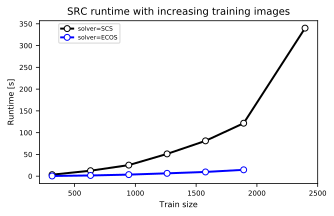

In [73]:
fig = plt.figure(figsize=(5,3))
#plt.plot(train_size, times)
plt.plot(train_size_scs, times_scs, '-ok', color='black',
         markersize=6, linewidth=2,
         markerfacecolor='white', label='solver=SCS')
plt.plot(train_size_ecos[:6], times_ecos[:6], '-ok', color='blue',
         markersize=6, linewidth=2,
         markerfacecolor='white', label='solver=ECOS')
plt.title('SRC runtime with increasing training images', fontdict=font_large)
plt.xlabel('Train size', fontdict=font_small)
plt.ylabel('Runtime [s]', fontdict=font_small)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(bbox_to_anchor=(0.3, 1), loc=1, prop={"size":6})

plt.savefig(f'Figures/runtimes_src.svg')